This experimental notebook attempts to take the normalizing flow structure developed by Francois Lanusse in this notebook: https://github.com/EiffL/jax-nf/blob/master/notebooks/NSF.ipynb and apply it to our photo-z catalogs.

This first part is just running the pieces from the original notebook but training it with one color plus redshift as the two dimensions.

In [4]:
%pylab inline 

%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'../../../jax-nf/')

from tensorflow_probability.python.internal.backend import jax as tf
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from jax_nf.real_nvp import RealNVP

In [6]:
from flax import nn
import jax
import jax.numpy as np
import numpy as onp
import flax 

tfb = tfp.bijectors
tfd = tfp.distributions

In [7]:
@nn.module
def NeuralSplineCoupling(x, nunits, nbins=32):

  def bin_positions(x):
    x = np.reshape(x, [-1, nunits, nbins])
    return nn.activation.softmax(x, axis=-1) *  (2. - nbins * 1e-2) + 1e-2
  
  def slopes(x):
    x = np.reshape(x, [-1, nunits, nbins - 1])
    return nn.activation.softplus(x) + 1e-2

  # Let's have one more non stupid layer
  net = nn.leaky_relu(nn.Dense(x, 128))
  net = nn.leaky_relu(nn.Dense(net, 128))

  bin_widths = bin_positions(nn.Dense(net, nunits*nbins))
  bin_heights = bin_positions(nn.Dense(net, nunits*nbins))
  knot_slopes = slopes(nn.Dense(net, nunits*(nbins-1)))

  return tfb.RationalQuadraticSpline(
            bin_widths=bin_widths,
            bin_heights=bin_heights,
            knot_slopes=knot_slopes)

In [8]:
# Instantiate the splines
d = 2
dummy_input = np.zeros((1, d//2))
_, params1 = NeuralSplineCoupling.init(jax.random.PRNGKey(0), dummy_input, d//2)

/global/homes/b/brycek/.conda/envs/bryce-desc/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [9]:
from functools import partial
spline1 = partial(NeuralSplineCoupling.call, params1)

In [10]:
nvp = tfd.TransformedDistribution(
        tfd.Normal(0,1),
        bijector=RealNVP(1, bijector_fn=spline1),
        event_shape=(2,))

In [11]:
samps = nvp.sample((1000,), seed=jax.random.PRNGKey(1))

/global/homes/b/brycek/.conda/envs/bryce-desc/lib/python3.8/site-packages/jax/numpy/lax_numpy.py:1531: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)
/global/homes/b/brycek/.conda/envs/bryce-desc/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/global/homes/b/brycek/.conda/envs/bryce-desc/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enab

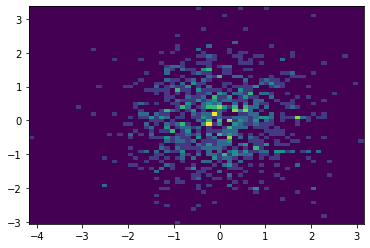

In [12]:
hist2d(samps[:,0], samps[:,1],64);

In [13]:
# Sweet :-D Hurray for TFP

In [14]:
# Let's try to learn a density

In [15]:
d=2
@nn.module
def NeuralSplineFlow(x):
    
    spline1 = NeuralSplineCoupling.shared(name='spline1')
    spline2 = NeuralSplineCoupling.shared(name='spline2')
    
    # Computes the likelihood of these x
    chain = tfb.Chain([
        tfb.Scale(10),
        RealNVP(d//2, bijector_fn=spline1),
        tfb.Permute([1,0]),
        RealNVP(d//2, bijector_fn=spline2),
        tfb.Permute([1,0]),
        tfb.Scale(0.1)
    ])
    
    nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=chain,
                event_shape=(d,))
    
    return nvp.log_prob(x)

In [16]:
dummy_input = np.zeros((1,d))
res, params = NeuralSplineFlow.init(jax.random.PRNGKey(0), dummy_input)

In [17]:
model = nn.Model(NeuralSplineFlow, params)

In [18]:
# Ok, sweet
@jax.jit
def train_step(optimizer, batch):
    
    def loss_fn(model):
        log_prob = model(batch['x'])
        return -np.mean(log_prob)
    
    loss, grad = jax.value_and_grad(loss_fn)(optimizer.target)
    optimizer = optimizer.apply_gradient(grad)
    return loss, optimizer

## Read in simulated data

Expensive to make but includes complex physical effects

In [21]:
from astropy.io import fits
import pandas as pd

In [22]:
hdulist = fits.open('/global/projecta/projectdirs/lsst/groups/PZ/PhotoZDC1/simulation_catalogs/buzzard_base/Final_Buzzard_training_file.fits')

In [23]:
data_df = pd.DataFrame(hdulist[1].data)

In [24]:
data_df.head()

,BuzzID,oldID,ecatID,ra,dec,redshift,mstar,LSSTu,LSSTg,LSSTr,LSSTi,LSSTz,LSSTy,errLSSTu,errLSSTg,errLSSTr,errLSSTi,errLSSTz,errLSSTy
0,4,1868,265694,63.197601,-41.453098,0.038356,2.692900e+09,17.8313,16.9077,16.4431,16.2099,16.0613,15.8732,0.0050,0.0050,0.005,0.0050,0.0050,0.0050
1,14,25650,215939,63.153801,-40.588200,0.058309,1.315350e+10,19.0731,17.7448,16.9789,16.5288,16.2551,15.9531,0.0051,0.0050,0.005,0.0050,0.0050,0.0050
2,18,30908,494449,63.624401,-42.628899,0.063701,4.831440e+07,21.6380,21.0106,20.8286,20.6283,20.6552,20.5280,0.0068,0.0051,0.005,0.0051,0.0052,0.0064
3,21,34983,159487,63.646999,-42.124901,0.059006,2.670790e+08,20.5474,19.5542,19.2387,19.0568,19.0887,18.9865,0.0055,0.0050,0.005,0.0050,0.0050,0.0051
4,22,36218,273518,63.472801,-42.423302,0.063202,4.825270e+07,21.2378,20.6876,20.5661,20.4371,20.4799,20.4503,0.0061,0.0051,0.005,0.0051,0.0052,0.0063


In [25]:
# To get rid of byte order issue:
# (See https://pandas.pydata.org/pandas-docs/version/0.19.1/gotchas.html#byte-ordering-issues)

for column_name in data_df.columns:
    data_df[column_name] = data_df[column_name].values.byteswap().newbyteorder()

In [26]:
print(data_df.columns)

Index(['BuzzID', 'oldID', 'ecatID', 'ra', 'dec', 'redshift', 'mstar', 'LSSTu',
       'LSSTg', 'LSSTr', 'LSSTi', 'LSSTz', 'LSSTy', 'errLSSTu', 'errLSSTg',
       'errLSSTr', 'errLSSTi', 'errLSSTz', 'errLSSTy'],
      dtype='object')


## Clean up data and prepare training catalog

From our scatter plot we can see that missing data is recorded as 99. Let's only take values where we have all the magnitudes for the galaxy.

Text(0, 0.5, 'LSSTg')

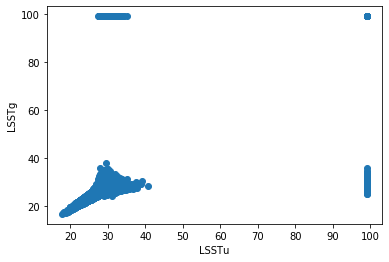

In [27]:
plt.scatter(data_df['LSSTu'], data_df['LSSTg'])
plt.xlabel('LSSTu')
plt.ylabel('LSSTg')

In [28]:
clean_data_df = data_df.query('%s < 90. and %s < 90. and %s < 90. and %s < 90. and %s < 90. and %s < 90.' % ('LSSTu',
                                                                                                             'LSSTg',
                                                                                                             'LSSTr',
                                                                                                             'LSSTi',
                                                                                                             'LSSTz',
                                                                                                             'LSSTy'))

In [29]:
clean_data_df = clean_data_df.reset_index(drop=True)

In [30]:
clean_data_df.head()

,BuzzID,oldID,ecatID,ra,dec,redshift,mstar,LSSTu,LSSTg,LSSTr,LSSTi,LSSTz,LSSTy,errLSSTu,errLSSTg,errLSSTr,errLSSTi,errLSSTz,errLSSTy
0,4,1868,265694,63.197601,-41.453098,0.038356,2.692900e+09,17.8313,16.9077,16.4431,16.2099,16.0613,15.8732,0.0050,0.0050,0.005,0.0050,0.0050,0.0050
1,14,25650,215939,63.153801,-40.588200,0.058309,1.315350e+10,19.0731,17.7448,16.9789,16.5288,16.2551,15.9531,0.0051,0.0050,0.005,0.0050,0.0050,0.0050
2,18,30908,494449,63.624401,-42.628899,0.063701,4.831440e+07,21.6380,21.0106,20.8286,20.6283,20.6552,20.5280,0.0068,0.0051,0.005,0.0051,0.0052,0.0064
3,21,34983,159487,63.646999,-42.124901,0.059006,2.670790e+08,20.5474,19.5542,19.2387,19.0568,19.0887,18.9865,0.0055,0.0050,0.005,0.0050,0.0050,0.0051
4,22,36218,273518,63.472801,-42.423302,0.063202,4.825270e+07,21.2378,20.6876,20.5661,20.4371,20.4799,20.4503,0.0061,0.0051,0.005,0.0051,0.0052,0.0063


Create a training dataset only consisting of photometric information and redshift.

In [31]:
train_df = clean_data_df[['redshift', 'LSSTu', 'LSSTg', 'LSSTr', 'LSSTi', 'LSSTz', 'LSSTy',
                          'errLSSTu', 'errLSSTg', 'errLSSTr', 'errLSSTi', 'errLSSTz', 'errLSSTy']]

In [32]:
train_df.head()

,redshift,LSSTu,LSSTg,LSSTr,LSSTi,LSSTz,LSSTy,errLSSTu,errLSSTg,errLSSTr,errLSSTi,errLSSTz,errLSSTy
0,0.038356,17.8313,16.9077,16.4431,16.2099,16.0613,15.8732,0.0050,0.0050,0.005,0.0050,0.0050,0.0050
1,0.058309,19.0731,17.7448,16.9789,16.5288,16.2551,15.9531,0.0051,0.0050,0.005,0.0050,0.0050,0.0050
2,0.063701,21.6380,21.0106,20.8286,20.6283,20.6552,20.5280,0.0068,0.0051,0.005,0.0051,0.0052,0.0064
3,0.059006,20.5474,19.5542,19.2387,19.0568,19.0887,18.9865,0.0055,0.0050,0.005,0.0050,0.0050,0.0051
4,0.063202,21.2378,20.6876,20.5661,20.4371,20.4799,20.4503,0.0061,0.0051,0.005,0.0051,0.0052,0.0063


In [33]:
train_df.sample(n=512, replace=False)

,redshift,LSSTu,LSSTg,LSSTr,LSSTi,LSSTz,LSSTy,errLSSTu,errLSSTg,errLSSTr,errLSSTi,errLSSTz,errLSSTy
4661,0.470641,27.6463,26.2598,24.6927,23.9362,23.5836,23.3627,1.0008,0.0784,0.0169,0.0160,0.0223,0.0517
37254,1.343310,27.1704,26.9398,26.5707,26.2055,25.8364,25.0712,0.6059,0.1529,0.0940,0.1051,0.1389,0.2199
46463,0.593285,29.0857,27.8034,26.8519,26.3687,26.4994,26.2063,0.7798,0.2098,0.1143,0.1560,0.2791,0.6503
57231,1.366150,26.7123,26.5994,26.5816,26.7813,26.3739,25.5549,0.3134,0.0942,0.0880,0.1525,0.2518,0.4949
42375,0.363201,26.4749,25.9257,25.1012,24.8329,24.6288,24.8939,0.3029,0.0551,0.0239,0.0367,0.0604,0.1700
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35351,1.126810,23.9630,23.7976,23.4863,22.9080,22.1764,21.8009,0.0313,0.0099,0.0073,0.0078,0.0078,0.0136
98089,1.408710,24.7613,24.4216,24.2093,23.7616,23.3409,22.6052,0.0623,0.0155,0.0116,0.0134,0.0184,0.0280
50571,0.789929,25.8257,25.4838,24.9003,24.0109,23.7114,23.6579,0.1595,0.0392,0.0193,0.0170,0.0261,0.0712
95390,1.078110,26.1180,25.6596,25.2001,24.6576,23.9800,23.6232,0.1664,0.0436,0.0254,0.0293,0.0313,0.0668


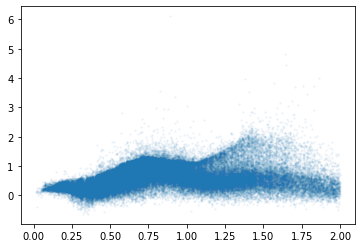

In [41]:
plt.scatter(train_df['redshift'], train_df['LSSTr']-train_df['LSSTi'], s=2, alpha=0.05)

In [86]:
# Experimenting with only a fixed number of points
batch_size=512
def get_batch():
    rand_select = train_df.sample(n=2048, replace=False)
    x = np.array([rand_select['redshift'].values, rand_select['LSSTr'].values - rand_select['LSSTi'].values])
    x = x.T
    return {'x': x}

In [87]:
get_batch()

{'x': DeviceArray([[0.18995 , 0.1763  ],
              [1.38918 , 0.7977  ],
              [0.687226, 0.6365  ],
              ...,
              [0.666772, 0.5088  ],
              [0.661564, 0.5031  ],
              [0.42959 , 0.2337  ]], dtype=float32)}

In [88]:
# okokokok, let's try it out
optimizer = flax.optim.Adam(learning_rate=0.001).create(model)
losses = []

In [89]:
for i in range(2000):
    batch = get_batch()
    l, optimizer = train_step(optimizer, batch)
    losses.append(l)
    if  i % 100 == 0:
        print(l)

2.4404883
0.6527598
0.54919046
0.523595
0.5673105
0.5553997
0.5861708
0.47575068
0.5308359
0.5327577
0.5056985
0.5415348
0.49652016
0.5266391
0.554278
0.4903887
0.52913356
0.48160303
0.5163708
0.52911687


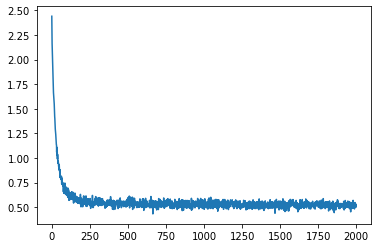

In [90]:
plot(losses)

In [91]:
# ok, fine, let's see if we can rebuild our flow
@nn.module
def NeuralSplineFlowSampler(key, n_samples):
    
    spline1 = NeuralSplineCoupling.shared(name='spline1')
    spline2 = NeuralSplineCoupling.shared(name='spline2')
    
    # Computes the likelihood of these x
    chain = tfb.Chain([
        tfb.Scale(10),
        RealNVP(d//2, bijector_fn=spline1),
        tfb.Permute([1,0]),
        RealNVP(d//2, bijector_fn=spline2),
        tfb.Permute([1,0]),
        tfb.Scale(0.1)
    ])
    nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=chain,
                event_shape=(d,))
    
    return nvp.sample(n_samples, seed=key)

In [92]:
sampler = nn.Model(NeuralSplineFlowSampler, optimizer.target.params)

In [93]:
samps = sampler(jax.random.PRNGKey(1),40000)

/global/homes/b/brycek/.conda/envs/bryce-desc/lib/python3.8/site-packages/jax/numpy/lax_numpy.py:1531: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)
/global/homes/b/brycek/.conda/envs/bryce-desc/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/global/homes/b/brycek/.conda/envs/bryce-desc/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enab

In [94]:
samps

DeviceArray([[0.97448874, 0.267874  ],
             [0.97662926, 0.92842233],
             [0.86097336, 0.7303947 ],
             ...,
             [0.48184854, 0.51118875],
             [0.9927838 , 1.1959798 ],
             [1.4050927 , 0.6202705 ]], dtype=float32)

Text(0, 0.5, 'r-i')

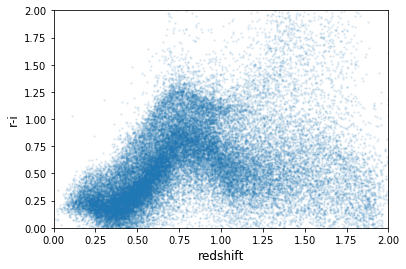

In [95]:
plt.scatter(samps[:,0], samps[:,1], s=2, alpha=0.1)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel('redshift', size=12)
plt.ylabel('r-i', size=12)

Text(0, 0.5, 'r-i')

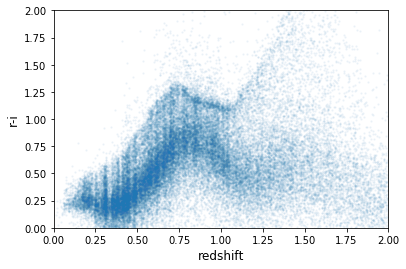

In [96]:
plt.scatter(train_df['redshift'][::2], train_df['LSSTr'][::2]-train_df['LSSTi'][::2], s=2, alpha=0.05)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel('redshift', size=12)
plt.ylabel('r-i', size=12)

### Use normalizing flow result to create p(z | color).

Now we want to adapt the normalizing flow for our problem. We need to be able to get the probability for specific color-redshift locations. If we do this for a range of redshifts at the same color we can get a conditional probability distribution for p(z | color).

In [97]:
nvp.log_prob??

Signature: nvp.log_prob(value, name='log_prob', **kwargs)
Source:   
  def log_prob(self, value, name='log_prob', **kwargs):
    """Log probability density/mass function.

    Args:
      value: `float` or `double` `Tensor`.
      name: Python `str` prepended to names of ops created by this function.
      **kwargs: Named arguments forwarded to subclass implementation.

    Returns:
      log_prob: a `Tensor` of shape `sample_shape(x) + self.batch_shape` with
        values of type `self.dtype`.
    """
    return self._call_log_prob(value, name, **kwargs)
File:      ~/.local/lib/python3.8/site-packages/tensorflow_probability/python/distributions/_jax/distribution.py
Type:      method


In [98]:
# ok, fine, let's see if we can rebuild our flow
@nn.module
def NeuralSplineFlowLogProb(point):
    
    spline1 = NeuralSplineCoupling.shared(name='spline1')
    spline2 = NeuralSplineCoupling.shared(name='spline2')
    
    # Computes the likelihood of these x
    chain = tfb.Chain([
        tfb.Scale(10),
        RealNVP(d//2, bijector_fn=spline1),
        tfb.Permute([1,0]),
        RealNVP(d//2, bijector_fn=spline2),
        tfb.Permute([1,0]),
        tfb.Scale(0.1)
    ])
    nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=chain,
                event_shape=(d,))
    
    return nvp.log_prob(point)

In [99]:
log_prob_return = nn.Model(NeuralSplineFlowLogProb, optimizer.target.params)

In [105]:
log_prob_return([[.25, .25]])

DeviceArray([0.5822842], dtype=float32)

In [110]:
# What is probability density function of redshift given r-i = 1.
redshift_color_points = []
for i in np.arange(0., 2.01, 0.01):
    redshift_color_points.append([i, 1.0])
log_prob_result = log_prob_return(redshift_color_points)

In [111]:
prob_result = np.exp(log_prob_result)

Text(0.5, 1.0, 'P(z | r-i=1.0)')

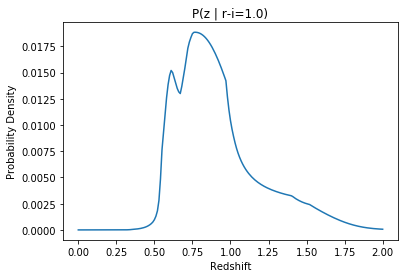

In [114]:
plt.plot(np.arange(0., 2.01, 0.01), prob_result/np.sum(prob_result))
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('P(z | r-i=1.0)')